# Solar Envelope

In this workshop we will learn how to compute the solar envelop of the building based on a voxelized building envelope.

## 0. Initialization
Importing all necessary libraries and specifying the inputs

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from ladybug.sunpath import Sunpath

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

## 1. Import Meshes (context + envelope)

### 1.1. Load Meshes

In [2]:
envelope_path = os.path.relpath('../Data/raw data/optional_envelope.obj')
context_path = os.path.relpath('../Data/raw data/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

True
False


### 1.2. Visualize Meshes (with pyvista)

In [3]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000019B9C66AAA0) at 0x0000019BA4191B80>

## 2. Import Lattice (envelope)

### 2.1. Load the Envelope Lattice

In [4]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

### 2.2. Visualize the Context Mesh + Envelope Lattice

In [5]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000019BA274FC40) at 0x0000019BA4254E80>

## 3. Sun Vectors

### 3.1. Compute Sun Vectors

In [6]:
# copy from green valley
sphere_mesh = tm.creation.icosphere(subdivisions=3, radius=1.0, color=None)
sphere_vectors = np.copy(sphere_mesh.vertices)

sky_vectors = []
for v in sphere_vectors:
    if v[2] > 0.0:
        sky_vectors.append(v)

sky_vectors = np.array(sky_vectors)
print(sky_vectors.shape)

(305, 3)


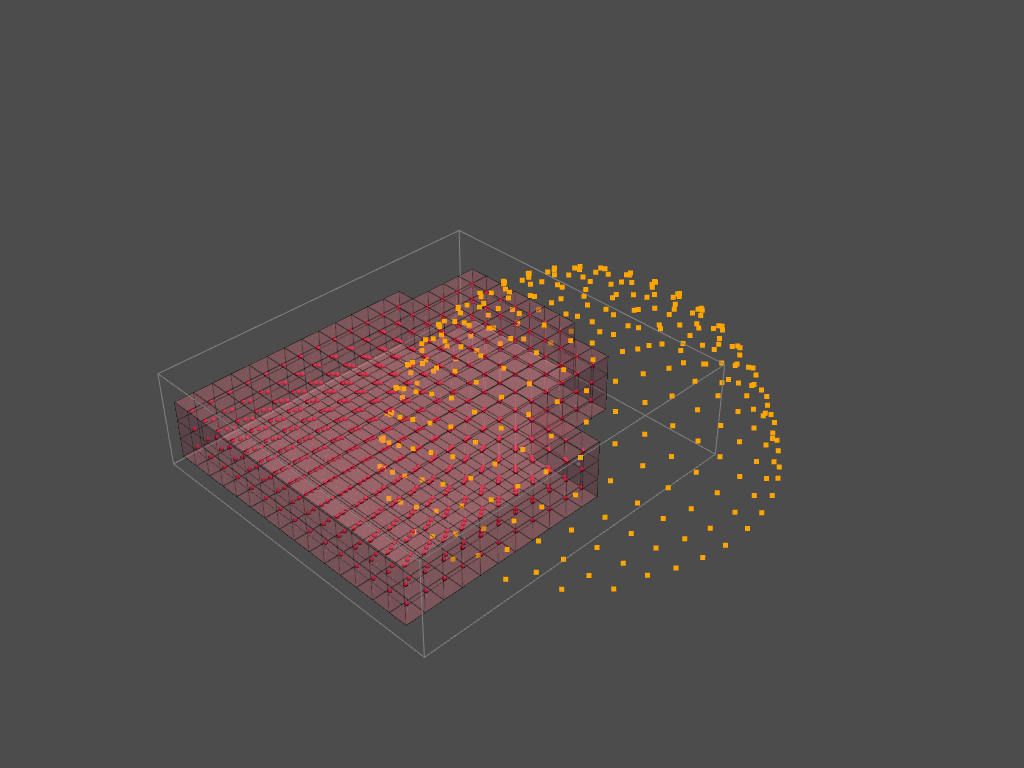

[(340.1025200054871, 302.2276089075671, 361.2200752837616),
 (16.63244472172552, -21.242466376194486, 37.75),
 (0.0, 0.0, 1.0)]

In [7]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(sphere_mesh), color='#aaaaaa')

# add the sun locations, color orange
p.add_points(sky_vectors * 80, color='#ffa500')

# plotting
p.show()

## 4. Compute Intersection of Sun Rays with Context Mesh

### 4.1. Preparing the List of Ray Directions and Origins

In [8]:
# exract the centroids of the envelope voxels
vox_cens = envelope_lattice.centroids
# next step we need to shoot in all of the sun directions from all of the voxels, todo so, we need repeat the sun direction for the number of voxels to construct the ray_dir (which is the list of all ray directions). We need to repeat the voxels for the 
sv_dir = []
sv_src = []
for v_cen in vox_cens:
    for s_dir in sky_vectors:
        sv_dir.append(s_dir)
        sv_src.append(v_cen)
# converting the list of directions and sources to numpy array
sv_dir = np.array(sv_dir)
sv_src = np.array(sv_src)

"""
# Further info: this is the vectorised version of nested for loops
ray_dir = np.tile(sun_dirs, [len(vox_cens),1])
ray_src = np.tile(vox_cens, [1, len(sun_dirs)]).reshape(-1, 3)
"""

print("number of voxels to shoot rays from :",vox_cens.shape)
print("number of rays per each voxel :",sky_vectors.shape)
print("number of rays to be shooted :",sv_src.shape)

number of voxels to shoot rays from : (672, 3)
number of rays per each voxel : (305, 3)
number of rays to be shooted : (204960, 3)


### 4.2. Computing the Intersection

In [9]:
# computing the intersections of rays with the context mesh
tri_sv_id, ray_sv_id = context_mesh.ray.intersects_id(ray_origins=sv_src, ray_directions=sv_dir, multiple_hits=False)

## 5. Aggregate Simulation Result in the Sun Access Lattice

### 5.1. Compute the percentage of time that each voxel sees the sun

In [10]:
sv_hits = [0]*len(sv_dir)

for id in ray_sv_id:
    sv_hits[id] = 1

sun_count = len(sky_vectors)
vox_count = len(vox_cens)

# initiating the list of ratio
vox_sv = []
# iterate over the voxels
for v_id in range(vox_count):
    # counter for the intersection
    sv_count = 0
    # iterate over the sun rays
    for s_id in range(sun_count):
        # computing the ray id from voxel id and sun id
        r_id = v_id * sun_count + s_id

        # summing the intersections
        sv_count += sv_hits[r_id]
    
    # computing the percentage of the rays that DID NOT have 
    # an intersection (aka could see the sun)
    sv = 1.0 - sv_count/sun_count

    # add the ratio to list
    vox_sv.append(sv)

sv_hits = np.array(sv_hits)

vox_sv = np.array(vox_sv)

### 5.2. Store sun access information in a Lattice

In [11]:
# getting the condition of all voxels: are they inside the envelop or not
env_all_vox = envelope_lattice.flatten()

# all voxels sun access
all_vox_sv = []

# v_id: voxel id in the list of only interior voxels
v_id = 0

# for all the voxels, place the interiority condition of each voxel in "vox_in"
for vox_in in env_all_vox:
    # if the voxel was outside...
    if vox_in == True:
        # read its value of sun access and append it to the list of all voxel sun access
        all_vox_sv.append(vox_sv[v_id])
        # add one to the voxel id so the next time we read the next voxel
        v_id += 1
    # if the voxel was not inside... 
    else:
        # add 0.0 for its sun access
        all_vox_sv.append(0)


# convert to array
sv_array = np.array(all_vox_sv)

# reshape to lattice shape
sv_array = sv_array.reshape(envelope_lattice.shape)

# convert to lattice
sv_lattice = tg.to_lattice(sv_array, envelope_lattice)

print(sv_lattice.shape)

(18, 17, 5)


### 5.3. Visualize the sun access lattice

In [12]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = sv_lattice
# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sky View Factor"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

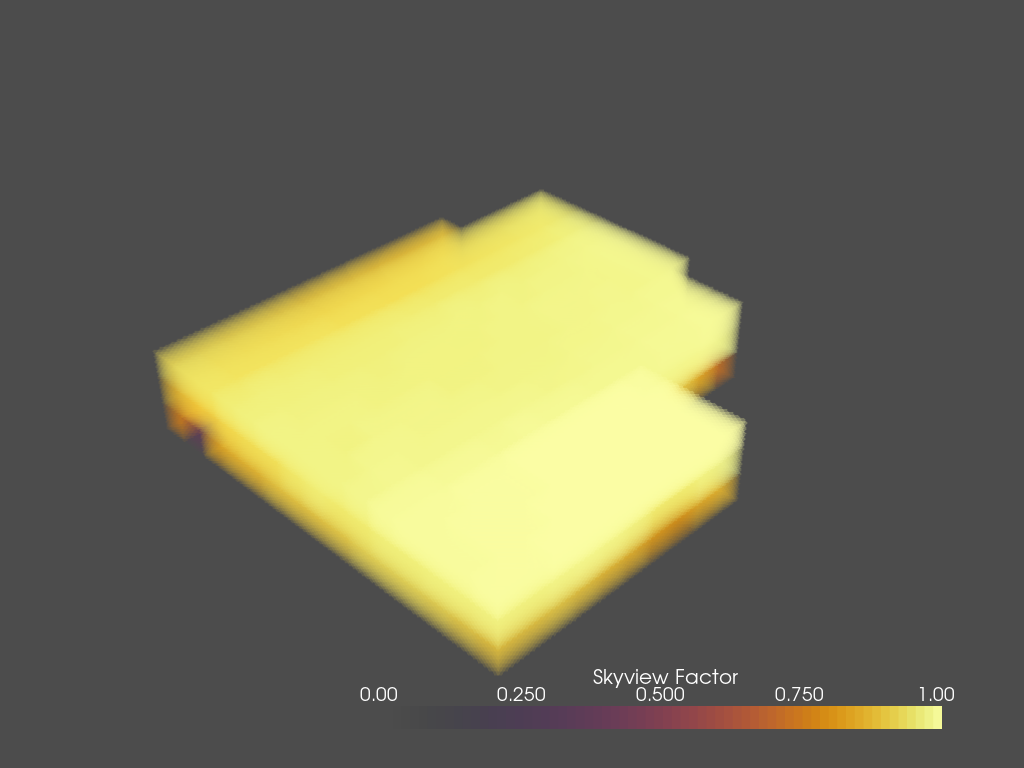

[(269.2590662461598, 192.75906624615982, 255.75906624615982),
 (31.5, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [13]:
# initiating the plotter
p = pv.Plotter()

l = sv_lattice

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Skyview Factor"] = l.flatten(order="F")  # Flatten the Lattice

# adding the volume
p.add_volume(grid, cmap="inferno", shade=False, show_scalar_bar=True)

# plotting
p.show()

## 6. Save Sun Access Lattice into a CSV

In [14]:
# save the sky view factor latice to csv
csv_path = os.path.relpath('../Data/dynamic output/skyview.csv')
sv_lattice.to_csv(csv_path)

### Credits

In [15]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Solar Envelope"